In [1]:
import numpy as np
import tensorflow.keras as k
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from scipy.special import inv_boxcox, softmax
from scipy.stats import boxcox
import scipy.stats as st
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
from tqdm import tqdm
import pickle 


In [108]:
conn = sqlite3.connect('../../data/baza_projekt.db')
# counties = pd.read_sql_query('SELECT * FROM unemployment', conn).iloc[:, :3]
counties = pd.read_sql_query(""" 
select e.[FIPS code],
       e.State,
       e.[Area name],
       "Percent of adults completing some college or associate's degree, 2017-21"  + "Percent of adults with a bachelor's degree or higher, 2017-21" as "Higher Education",
       "2016 HPI Change" as HPI,
       "2016 Population (persons) 1/" as Income,
       "Unemployment_rate_2016" as Unemployment,
       "Poor physical health days raw value 2016" as "Poor physical health days",
       "Poor mental health days raw value 2016" as "Poor mental health days",
       "Violent crime raw value 2016" as "Violent crime",
       "Severe housing problems raw value 2016" as "Severe housing problems",
       "Income inequality raw value 2016" as "Income inequality",
       "Access to exercise opportunities raw value 2016" as "Access to exercise opportunities"
from education as e
    inner join hpi as h on h.[FIPS code] = e.[FIPS code]
    inner join income as i on i.[FIPS code] = e.[FIPS code]
    inner join unemployment as u on u.[FIPS code] = e.[FIPS code]
    inner join health as he on he.[FIPS code] = e.[FIPS code]
    """,
    conn
    )


population = pd.read_sql_query("""select "FIPS code", POPESTIMATE2020 as Population
                from population 
    """,
    conn)

population_chg = pd.read_sql_query("""select "FIPS code", NPOPCHG2020 + NPOPCHG2021 + NPOPCHG2022 as POPCHG
                from population 
    """,
    conn)


counties['FIPS code'] = counties['FIPS code'].astype(str).apply(lambda x: '0'+x if len(x)==4 else x)
counties = counties.fillna(value=0)
conn.close()
counties.head()

,FIPS code,State,Area name,Higher Education,HPI,Income,Unemployment,Poor physical health days,Poor mental health days,Violent crime,Severe housing problems,Income inequality,Access to exercise opportunities
0,01001,Alabama,Autauga County,56.825870,2.64,56954,5.1,4.4,4.3,253.644617,0.136193,4.303481,0.708215
1,01003,Alabama,Baldwin County,63.638665,5.20,210004,5.4,4.1,4.2,220.665106,0.147079,4.494800,0.721685
2,01005,Alabama,Barbour County,38.994165,-0.68,26217,8.4,4.9,4.7,146.888576,0.175597,5.285567,0.452671
3,01007,Alabama,Bibb County,36.619543,3.95,22654,6.5,4.8,4.6,235.952110,0.129993,4.251361,0.328388
4,01009,Alabama,Blount County,48.524639,1.66,58238,5.4,4.6,4.5,219.034344,0.123395,4.124186,0.255085


In [109]:
virtual_df = pd.read_csv('../../data/processed/migration_matrix.csv', sep=';', index_col='Unnamed: 0')

virtual_df.columns = virtual_df.columns.astype(str).map(lambda x: '0' + x if len(x) == 4 else x)
virtual_df.index = virtual_df.index.astype(str).map(lambda x: '0' + x if len(x) == 4 else x)
population['FIPS code'] = population['FIPS code'].astype(str).map(lambda x: '0' + x if len(x) == 4 else x)
population_chg['FIPS code'] = population_chg['FIPS code'].astype(str).map(lambda x: '0' + x if len(x) == 4 else x)


virtual_df = virtual_df.filter(items=counties['FIPS code'])

virtual_df = virtual_df.reindex(counties['FIPS code'])
virtual_df = virtual_df.dropna()

virtual_df.shape

(2703, 2703)

In [110]:
population = population[population['FIPS code'].isin(virtual_df.index)]
population = population.set_index(['FIPS code'])

population_chg = population_chg[population_chg['FIPS code'].isin(virtual_df.index)]
population_chg = population_chg.set_index(['FIPS code'])

In [5]:
counties.set_index('FIPS code', inplace=True)
counties = counties.reindex(virtual_df.index)
counties = counties.dropna()

counties.reset_index(inplace=True)

Pozbywamy się wartości ujemnych i zer

In [6]:
hpi_shift = np.min(counties['HPI']) 
counties['HPI'] -= hpi_shift

In [7]:
eps = 1e-15
counties.replace(0, eps, inplace=True)

In [8]:
virtual_df.head()

# Z *kolumy* przyjechało *komórka* ludzi do *wiersza*

,01001,01003,01005,01007,01009,01013,01015,01017,01019,01021,...,56025,56029,56031,56033,56035,56037,56039,56041,56043,56045
FIPS code,,,,,,,,,,,,,,,,,,,,,
01001,0.0,30.0,5.0,12.0,0.0,0.0,2.0,0.0,6.0,22.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01003,489.0,0.0,0.0,0.0,24.0,24.0,44.0,0.0,6.0,2.0,...,0.0,53.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01005,0.0,5.0,0.0,14.0,0.0,0.0,16.0,11.0,29.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01007,48.0,7.0,38.0,0.0,33.0,10.0,72.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01009,0.0,18.0,0.0,19.0,0.0,0.0,42.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
percent_ludzi = (virtual_df.sum(axis=1).values / population.values.reshape(-1))

In [10]:
virtual_df.loc['01001', (virtual_df.iloc[0] != 0.0)].index

Index(['01003', '01005', '01007', '01015', '01019', '01021', '01035', '01047',
       '01051', '01055', '01073', '01077', '01081', '01083', '01093', '01095',
       '01097', '01101', '01103', '01113', '01115', '01117', '01123', '01127',
       '01131', '04003', '12009', '12057', '13077', '13135', '13235', '18097',
       '21001', '22011', '22015', '24003', '24021', '26077', '27159', '29189',
       '32003', '34035', '35009', '37031', '40137', '41059', '45085', '47011',
       '47113', '47153', '47187', '48121', '48201', '48329', '51013', '51107',
       '54107', '55141', '56021'],
      dtype='object')

In [11]:
counties.loc[counties['FIPS code'] == '01001']

,FIPS code,State,Area name,Higher Education,HPI,Income,Unemployment,Poor physical health days,Poor mental health days,Violent crime,Severe housing problems,Income inequality,Access to exercise opportunities
0,01001,Alabama,Autauga County,56.82587,23.92,56954,5.1,4.4,4.3,253.644617,0.136193,4.303481,0.708215


In [12]:
scaler = MinMaxScaler()
counties_scaled = pd.DataFrame(scaler.fit_transform(counties.values[:, 3:]), columns=counties.columns[3:])
counties_scaled.head()

,Higher Education,HPI,Income,Unemployment,Poor physical health days,Poor mental health days,Violent crime,Severe housing problems,Income inequality,Access to exercise opportunities
0,0.505228,0.453116,0.005561,0.143498,0.511628,0.647059,0.143750,0.261370,0.258850,0.708215
1,0.611832,0.501610,0.020683,0.156951,0.441860,0.617647,0.125059,0.294071,0.290806,0.721685
2,0.226204,0.390225,0.002524,0.291480,0.627907,0.764706,0.083247,0.379733,0.422886,0.452671
3,0.189047,0.477931,0.002172,0.206278,0.604651,0.735294,0.133723,0.242748,0.250144,0.328388
4,0.375333,0.434552,0.005688,0.156951,0.558140,0.705882,0.124135,0.222929,0.228902,0.255085


### Trening modeli dla hrabstw

In [14]:
class County:
    def __init__(self, name, fips_code, feature_vector=None, migration_rate=None) -> None:
        self.name = name
        self.fips_code = fips_code
        self.feature_vector = feature_vector.astype(np.float64)
        self.scaled_featuers = None
        self.virtual_county = self._get_vitrtual_county()
        self.scaled_virtual = None
        self._scale()
        self.weights = 1 + (self.scaled_virtual - self.scaled_featuers)   
        self.std = None
        self.lamb = None
        self.mean = None
        self.migration_rate = migration_rate
        self.population_to_mig = None

    def _get_vitrtual_county(self):
        non_zero_df = virtual_df.loc[self.fips_code, (virtual_df.iloc[0] != 0.0)]
        if np.sum(non_zero_df.values) == 0:
            return self.feature_vector
        else:
            weights = non_zero_df.values / np.sum(non_zero_df.values)
            result = np.zeros(self.feature_vector.shape)
            for idx, fips in enumerate(non_zero_df.index):
                row = counties.loc[counties['FIPS code'] == fips]
                result += weights[idx] * row.iloc[:, 3:].to_numpy().astype(np.float64).reshape(-1)
            return result

    
    def _set_distribution_parameters(self, std, lamb):
        self.std = std.astype(np.float64)
        self.lamb = lamb.astype(np.float64)
        self.mean = boxcox(self.feature_vector, self.lamb)

    def _scale(self):
        self.scaled_featuers = scaler.transform(self.feature_vector.reshape(1 , -1)).reshape(-1)
        self.scaled_virtual = scaler.transform(self.virtual_county.reshape(1 , -1)).reshape(-1)
    
    def generate_random_vector(self):
        result = np.abs(np.random.normal(loc=self.mean, scale=self.std))
        # return  np.clip(result, self.mean - 3 * self.std, self.mean + 3 * self.std)
        return result


    def __str__(self) -> str:
        return f'{self.name}, {self.fips_code}, {self.feature_vector}'


class Person:
    def __init__(self, birthplace: County) -> None:
        self.birthplace: County = birthplace
        self.boxcox_features = None
        self.embeded_scaled_vector = None
        self.embeded_vector = None
        self.distance_from_bith = None
        self.migration_history = []
        self._sample_from_dist()
        self.feature_vector = self._inverse_transform_vec()
        self.scaled_featues = scaler.transform(self.feature_vector.reshape(1, -1)).reshape(-1)
    
    def _sample_from_dist(self):
        self.boxcox_features = self.birthplace.generate_random_vector()

    def embed(self):
        self.embeded_vector = np.multiply(self.birthplace.weights, self.scaled_featues)
        self.embeded_scaled_vector = scaler.transform(self.embeded_vector.reshape(1, -1)).reshape(-1)

    def _inverse_transform_vec(self):
        result = np.array([inv_boxcox(i_f, i_lambda) for i_f, i_lambda in zip(self.boxcox_features, self.birthplace.lamb)])
        for ix, el in enumerate(result):
            if np.isnan(el):
                result[ix] = self.birthplace.feature_vector[ix]
        tmp_std = inv_boxcox(self.birthplace.std, self.birthplace.lamb)
        result = np.clip(result, self.birthplace.feature_vector - 3 * tmp_std, self.birthplace.feature_vector + 3 * tmp_std)
        return result

In [15]:
counties_list: list[County] = []
for idx, row in tqdm(counties.iterrows()):
    counties_list.append(County(row['Area name'] + ', ' + row['State'], row['FIPS code'], feature_vector=row.iloc[3:].to_numpy(), migration_rate=percent_ludzi[idx]))


2703it [00:56, 47.54it/s]


In [16]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
import numpy as np


def get_even_clusters(X, cluster_size):
    n_clusters = int(np.ceil(len(X)/cluster_size))
    kmeans = KMeans(n_clusters)
    kmeans.fit(X)
    centers = kmeans.cluster_centers_
    centers = centers.reshape(-1, 1, X.shape[-1]).repeat(cluster_size, 1).reshape(-1, X.shape[-1])
    distance_matrix = cdist(X, centers)
    clusters = linear_sum_assignment(distance_matrix)[1]//cluster_size
    return n_clusters, clusters

feature_vectors = np.array([c.feature_vector for c in counties_list])

N_CLUSTERS, results = get_even_clusters(feature_vectors.astype(np.float64), 250)


c:\Users\Filif\anaconda3\envs\gpu\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Filif\anaconda3\envs\gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(


In [17]:
boxcox_params = dict()
for cluster in range(N_CLUSTERS):
    group = np.array(counties_list)[results==cluster]
    cluster_features = np.array(list(map(lambda x: x.feature_vector, group)))
    boxcox_params[cluster] = {
        'lmbds' : np.zeros(cluster_features.shape[1]),
        'stds' : np.zeros(cluster_features.shape[1])
    }
    lmbds = np.zeros(cluster_features.shape[1])
    stds = np.zeros(cluster_features.shape[1])
    for i, feature in enumerate(cluster_features.T):
        col_bc, lmbda = boxcox(feature)
        params = st.norm.fit(col_bc)
        boxcox_params[cluster]['lmbds'][i] = lmbda
        boxcox_params[cluster]['stds'][i] = params[1]
# with open('./boxed_coxed_distributions_clusters.pickle', 'wb') as handle:
#     pickle.dump(boxcox_params, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [18]:
# with open('./boxed_coxed_distributions_clusters.pickle', 'rb') as handle:
#     boxcox_params = pickle.load(handle)

In [19]:
for i, county in enumerate(counties_list):
    county._set_distribution_parameters(boxcox_params[results[i]]['stds'],
                                        boxcox_params[results[i]]['lmbds'])

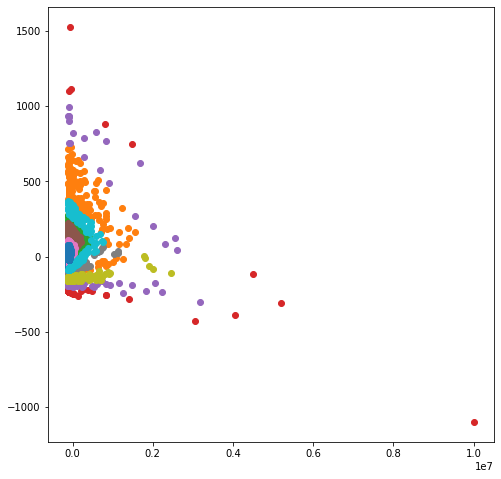

In [20]:
from sklearn.manifold import TSNE

u_labels = np.unique(results)
pca = PCA(2)
df = pca.fit_transform(feature_vectors)
#plotting the results:
plt.figure(figsize=(8,8))
for i in u_labels:
    plt.scatter(df[results == i , 0] , df[results == i , 1] , label = i)
plt.show()

### LOSOWANIE LUDZI

In [21]:
FRAC = 0.01

people_dict: dict[County, list[Person]] = {}
for county in tqdm(counties_list):
    people_count = int(population.loc[county.fips_code] * FRAC)
    county.population_to_mig = people_count
    people_dict[county] = [Person(county) for _ in range(people_count)]

  0%|          | 0/2703 [00:00<?, ?it/s]

100%|██████████| 2703/2703 [06:17<00:00,  7.17it/s] 


### Generowanie nurków

In [22]:
embeded_pople = []
for cont, person_list in tqdm(people_dict.items()):
    for idx, prs in enumerate(person_list):
        prs.embed()
        embeded_pople.append(prs.embeded_scaled_vector)

embeded_pople = np.array(embeded_pople)
embeded_pople.shape

100%|██████████| 2703/2703 [02:48<00:00, 16.06it/s]


(3197078, 10)

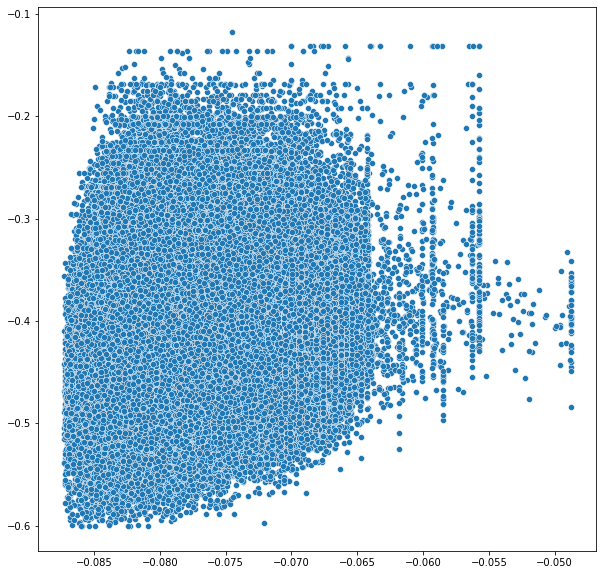

In [23]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x=embeded_pople[:, 3], y=embeded_pople[:, 4])
plt.show()

### Decyzja czy ktoś migruje czy nie

In [24]:
def calculate_distances():
    for kc, v in people_dict.items():
        for ppl in v:
            if ppl.migration_history:
                origin_couty = ppl.migration_history[-1]
            else:
                origin_couty = kc
            ppl.distance_from_bith = np.linalg.norm(ppl.embeded_scaled_vector - origin_couty.scaled_featuers)

In [36]:
from sklearn.neighbors import KDTree
from scipy.special import softmax


tree = KDTree(np.array([c.scaled_featuers for c in counties_list]))
def migrate():
    calculate_distances()
    for cnt, ppl_v in people_dict.items():
        dist_from_bith_tmp = []
        for ppl in ppl_v:
            dist_from_bith_tmp.append(ppl.distance_from_bith)
        n_people_migrate = int(cnt.population_to_mig * cnt.migration_rate)
        chosen_people_indexes = np.random.choice(list(range(cnt.population_to_mig)), size= n_people_migrate, replace=False,
                                        p=np.array(dist_from_bith_tmp) / np.sum(np.array(dist_from_bith_tmp)))

        for chosen_index in chosen_people_indexes:
            distances, idxs = tree.query(ppl_v[chosen_index].embeded_scaled_vector.reshape(1, -1), k = 100)

            ppl_v[chosen_index].migration_history.append(counties_list[np.random.choice(idxs.reshape(-1), replace=False, p=softmax(-distances).reshape(-1))])

In [41]:
EPOCHS = 10
migration_data = pd.DataFrame({'FIPS code': virtual_df.index, 'Population_base': [i.population_to_mig for i in counties_list]})

for epoch in range(EPOCHS):
    print(f"EPOCH {epoch + 1} / {EPOCHS}")
    migrate()

    county_pop = [0] * 2703
    for i, (k, v) in enumerate(people_dict.items()):
        for person in v:
            if person.migration_history:
                cnt_idx = counties_list.index(person.migration_history[-1])
                county_pop[cnt_idx] += 1
            else:
                county_pop[i] += 1
    migration_data[f'Population_epoch_{1 + epoch}'] = county_pop

EPOCH 1 / 10
EPOCH 2 / 10
EPOCH 3 / 10
EPOCH 4 / 10
EPOCH 5 / 10
EPOCH 6 / 10
EPOCH 7 / 10
EPOCH 8 / 10
EPOCH 9 / 10
EPOCH 10 / 10


In [127]:
import plotly.express as px

from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

In [92]:
from sklearn.metrics import accuracy_score

In [130]:
animated_data = pd.DataFrame(columns=["FIPS code", "Population", "Epoch"])

for i in range(EPOCHS + 1):
    epoch_data = pd.Series([i]*2703)
    if i == 0:
        tmp_data = pd.DataFrame({'FIPS code': migration_data["FIPS code"], "Population":[0]*2703, 'Epoch': epoch_data, "Class_Error":[0]*2703, "Error":[0]*2703})
    else:
        tmp_data = pd.DataFrame({'FIPS code': migration_data["FIPS code"], "Population": migration_data[f"Population_epoch_{i}"] - migration_data['Population_base'],
                                 'Epoch': epoch_data, 'Class_Error': (population_chg.values.reshape(-1) > 0) == ((migration_data[f"Population_epoch_{i}"] - migration_data['Population_base']).values > 0),
                                 'Error': np.abs(migration_data[f"Population_epoch_{i}"].values - (population * FRAC).values.reshape(-1)) / (population.values.reshape(-1) * FRAC)})
    
    animated_data = pd.concat([animated_data, tmp_data], axis=0)

animated_data['Class_Error'] = pd.to_numeric(animated_data['Class_Error'])
animated_data['Population'] = pd.to_numeric(animated_data['Population']) 
animated_data['Epoch'] = pd.to_numeric(animated_data['Epoch']) 

In [129]:
fig = px.choropleth(animated_data, geojson=counties, locations='FIPS code', color='Population', animation_frame="Epoch",
                           scope="usa",
                           range_color=(-3_000, 3_000),
                           # color_discrete_map=color_map,
                           # category_orders={'change_label': ['above 15', '5 to 15', '0 to 5', '-5 to 0', '-15 to -5', 'below -15']}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.write_html('XD.html')

In [122]:
fig = px.choropleth(animated_data, geojson=counties, locations='FIPS code', color='Error', animation_frame="Epoch",
                           scope="usa",
                           range_color=(0, 10),
                           # color_discrete_map=color_map,
                           # category_orders={'change_label': ['above 15', '5 to 15', '0 to 5', '-5 to 0', '-15 to -5', 'below -15']}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.write_html('error_xd.html')

TypeError: Object of type DataFrame is not JSON serializable

In [131]:
fig = px.choropleth(animated_data, geojson=counties, locations='FIPS code', color='Class_Error', animation_frame="Epoch",
                           scope="usa",
                        #    range_color=(0, 10),
                           # color_discrete_map=color_map,
                           # category_orders={'change_label': ['above 15', '5 to 15', '0 to 5', '-5 to 0', '-15 to -5', 'below -15']}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.write_html('error_xd.html')

In [51]:
population_small = population * FRAC

In [58]:
comparison_data = pd.merge(population_small, migration_data[['FIPS code', 'Population_epoch_10']], how='inner', on='FIPS code')

In [59]:
comparison_data.head()

,FIPS code,Population,Population_epoch_10
0,01001,589.02,252
1,01003,2332.19,1685
2,01005,249.60,148
3,01007,221.83,76
4,01009,591.02,362


In [64]:
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse, mean_absolute_percentage_error as mape

In [68]:
errors = []

for i in range(EPOCHS):
    errors.append(mae(comparison_data['Population'], migration_data[f'Population_epoch_{i + 1}']))
errors


[448.5985756566777,
 505.9428227894932,
 559.4525009248983,
 609.6744765075842,
 656.9257306696263,
 701.1835405105438,
 743.029001109878,
 782.2750240473548,
 819.3548242693305,
 854.3640732519424]

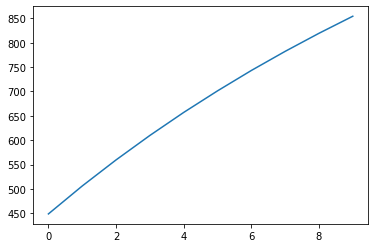

In [69]:
plt.plot(errors)

In [ ]:
fig = px.choropleth(animated_data, geojson=counties, locations='FIPS code', color='Population', animation_frame="Epoch",
                           scope="usa",
                           range_color=(-3_000, 3_000),
                           # color_discrete_map=color_map,
                           # category_orders={'change_label': ['above 15', '5 to 15', '0 to 5', '-5 to 0', '-15 to -5', 'below -15']}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.write_html('XD.html')